<a href="https://colab.research.google.com/github/Junyoungs7/Colab_ML_DL_Python/blob/main/CIFAR_10(transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.layers import BatchNormalization

SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.keras import datasets
cifar10 = datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

x_train = x_train/255.
x_test = x_test/255.

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


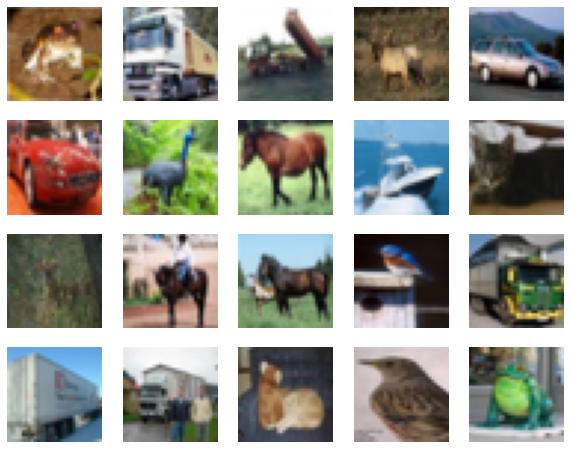

In [7]:
plt.figure(figsize=(10,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(x_train[i])
  plt.axis('off')

plt.show()

일반 CNN으로 분류 예측

In [14]:
def build_cnn():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=[32,32,3]))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=10, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        2432      
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          51264     
                                                                 
 batch_normalization_3 (Batc  (None, 2, 2, 64)         256       
 hNormalization)                                                 
                                                      

합성곱 레이어와 풀링 레이어 사이에 배치 정규화 레이어 추가 : 딥러닝에서 각 레이어를 거칠 때마다 입출력 데이터의 분포가 변화되는데 배치 정규화를 통해 정규분포와 비슷한 형태로 변환해 준다. -> 빠르고 안정적인 학습

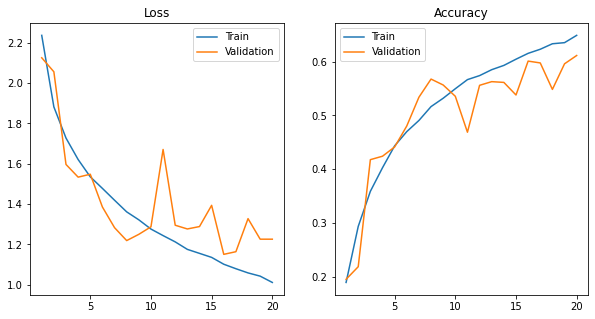

In [15]:
cnn_history = cnn_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.1, verbose=0)

def plot_metrics(history, start=1, end=20):
  fig, axes = plt.subplots(1, 2, figsize=(10,5))
  axes[0].plot(range(start, end+1), history.history['loss'][start-1:end], label='Train')
  axes[0].plot(range(start, end+1), history.history['val_loss'][start-1:end], label='Validation')
  axes[0].set_title('Loss')
  axes[0].legend()

  axes[1].plot(range(start, end+1), history.history['accuracy'][start-1:end], label='Train')
  axes[1].plot(range(start, end+1), history.history['val_accuracy'][start-1:end], label='Validation')
  axes[1].set_title('Accuracy')
  axes[1].legend()

plt.show()
plot_metrics(history=cnn_history, start=1, end=20)

transfer learning 사용 : ResNet50 모델 사용, include_top옵션 = False하면 모델의 분류기 역할을 하는 부분을 제외하고 가져옴, weigthts 옵셥의 imagenet은 ImageNet 데이터로 학습한 가중치를 가져온다는 뜻, 입력 크기와 분류클래스 개수를 지정
Flatten레이어를 사용하여 cnn_base 모델의 출력층을 1차원 배열로 변환하고 MLP모델에 연결

In [16]:
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', input_shape=[32,32,3], classes=10)

def build_transfer():
  transfer_model = Sequential()
  transfer_model.add(cnn_base)
  transfer_model.add(Flatten())

  transfer_model.add(Dense(units=64, activation='relu'))
  transfer_model.add(Dropout(rate=0.5))
  transfer_model.add(Dense(units=32, activation='relu'))
  transfer_model.add(Dropout(rate=0.5))
  transfer_model.add(Dense(units=10, activation='softmax'))

  transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return transfer_model

transfer_model = build_transfer()
transfer_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                       

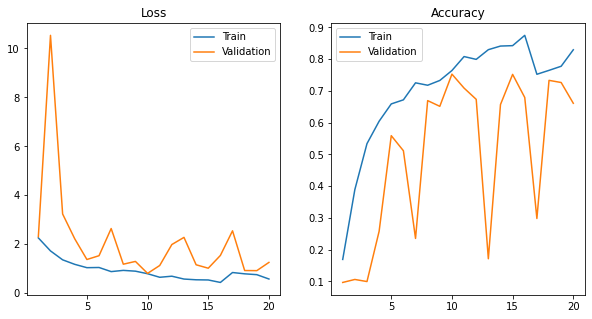

In [17]:
tm_history = transfer_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.1, verbose=0)
plot_metrics(history=tm_history, start=1, end=20)

예제를 보면서 따라 쳤다 예제 사진은 단순 CNN했을때보다 더 안정적으로 보인다고 하지만 위 그래프와 위위 그래프를 보면 위 그래프가 더 지랄났다;;
검증 정확도가 50~60% 수준에서 70%수준으로 향상됬다는데 단순 CNN이 더 안정적이고 정화도도 높아보인다. 둘다 과대적합이 보이므로 추후 고려